In [32]:
import json
import pandas as pd

# Load the JSON data
with open('/scratch/cognit/edge-clusters.json', 'r') as file:
    data = json.load(file)

# Function to get the carbon intensity data and interpolate to second-level resolution
def get_carbon_intensity(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)  # Ensure datetime is in UTC
    df = df.set_index('datetime').resample('S').interpolate(method='linear').reset_index()  # Interpolate to second resolution
    return df

# Function to load workload trace data and adjust timestamps
def load_workload_trace(file_path, start_datetime):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_timedelta(df['timestamp'], unit='s') + start_datetime  # Adjust to start from the first date of carbon intensity
    return df

# Function to calculate CO2 emission and energy used
def calculate_emissions_and_energy(power_draw_w, carbon_intensity_gco2_per_kwh):
    # Convert carbon intensity from gCO2/kWh to gCO2/Wh
    carbon_intensity_gco2_per_wh = carbon_intensity_gco2_per_kwh / 1000
    # Calculate energy used in watt-hours (Wh)
    energy_used_wh = power_draw_w / 3600  # since power_draw_w is in watts and we have power draw per second
    # Calculate CO2 emission (gCO2) using the power draw (W) and carbon intensity (gCO2/Wh)
    co2_emission_g = power_draw_w * carbon_intensity_gco2_per_wh / 3600  # in gCO2
    return co2_emission_g, energy_used_wh

# Loop through each entry in the JSON data
results = []
for entry in data:
    name = entry['name']
    carbon_intensity_file = entry['carbon-intensity-trace']
    workload_trace_file = '/scratch/cognit/workloads/3.csv'  # Fixed path to workload trace file

    # Load the carbon intensity data
    carbon_intensity_df = get_carbon_intensity(carbon_intensity_file)
    
    # Get the start date from the carbon intensity data
    start_datetime = carbon_intensity_df['datetime'].min()
    
    # Load the workload trace data and adjust the timestamps
    workload_trace_df = load_workload_trace(workload_trace_file, start_datetime)

    
    # Merge data on the second-level datetime
    merged_df = pd.merge_asof(workload_trace_df.sort_values('timestamp'), 
                              carbon_intensity_df.sort_values('datetime'), 
                              left_on='timestamp', 
                              right_on='datetime',
                              direction='nearest')
    
    
    # Calculate total CO2 emissions and total energy used
    merged_df[['co2_emission_g', 'energy_used_wh']] = merged_df.apply(
        lambda row: pd.Series(calculate_emissions_and_energy(row['power_draw_W'], row['carbonIntensity'])), axis=1)
    
    total_co2_emission = merged_df['co2_emission_g'].sum()
    total_energy_used_wh = merged_df['energy_used_wh'].sum()
    
    # Calculate workload duration in hours
    workload_duration_hours = (merged_df['timestamp'].max() - merged_df['timestamp'].min()).total_seconds() / 3600
    
    # Store the result
    results.append({
        'EdgeCluster': name, 
        'Total CO2 Emission (g)': total_co2_emission, 
        'Total Energy Used (Wh)': total_energy_used_wh, 
        'Workload Duration (hours)': workload_duration_hours
    })

# Convert results to a DataFrame and display without index
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


     EdgeCluster  Total CO2 Emission (g)  Total Energy Used (Wh)  Workload Duration (hours)
           Lulea                1.459930               27.276395                   0.349167
       Stockholm                0.540768               27.276395                   0.349167
            Lund                1.459930               27.276395                   0.349167
       Amsterdam                2.681322               27.276395                   0.349167
         Brussel                1.742214               27.276395                   0.349167
          Berlin                5.841005               27.276395                   0.349167
            Rome                5.028758               27.276395                   0.349167
          Warsaw               21.059044               27.276395                   0.349167
           Paris                0.490975               27.276395                   0.349167
          London                3.162777               27.276395                

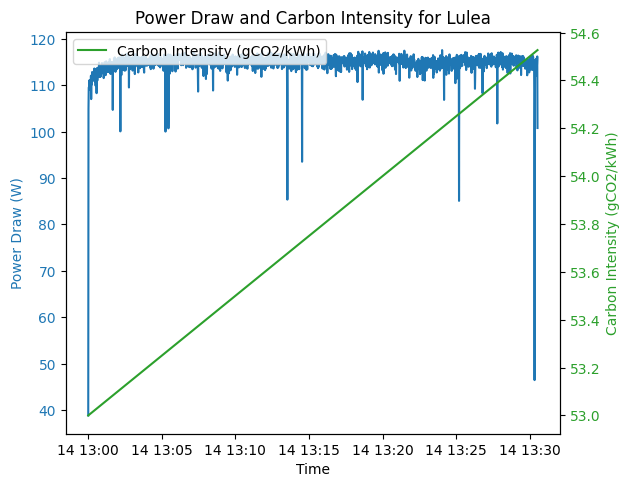

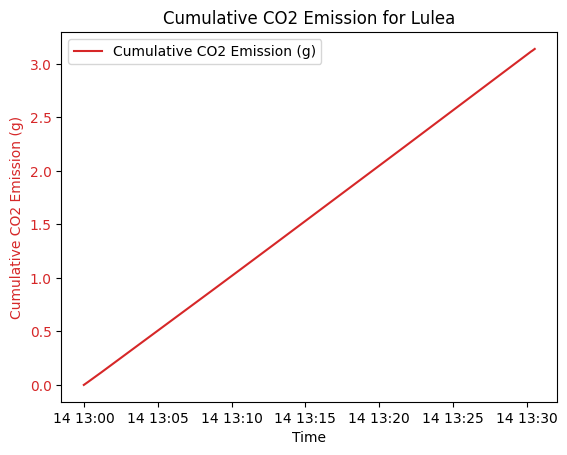

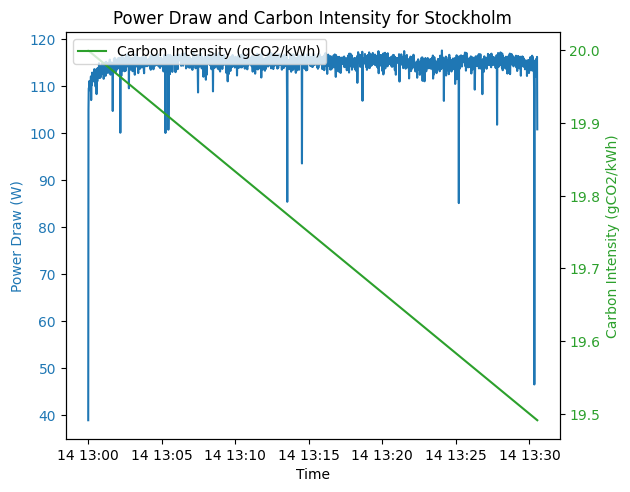

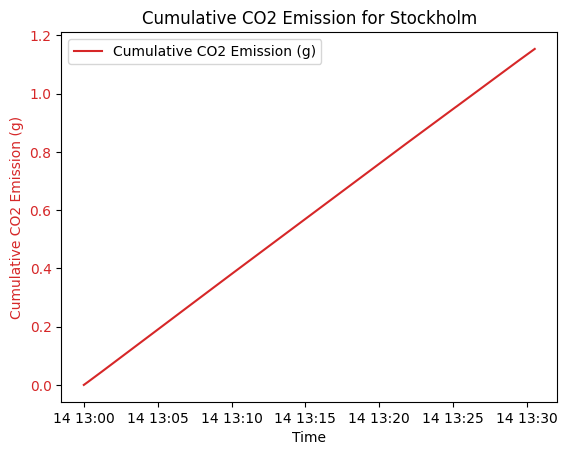

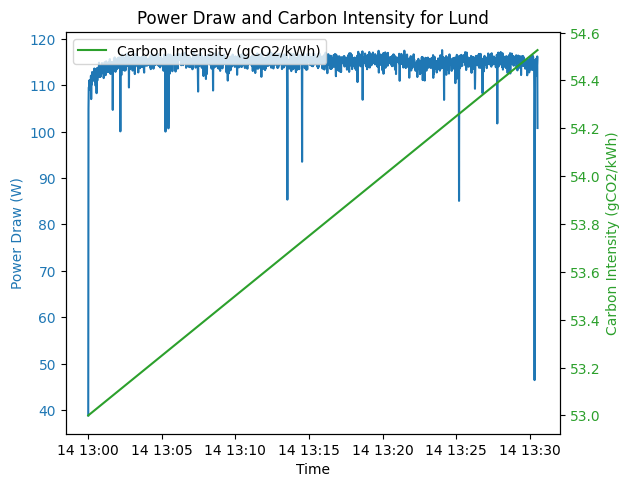

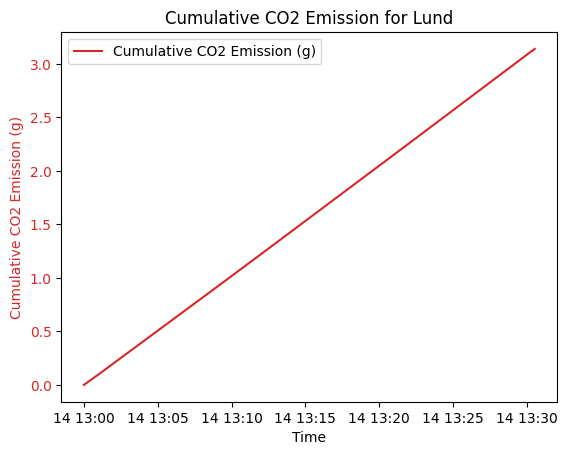

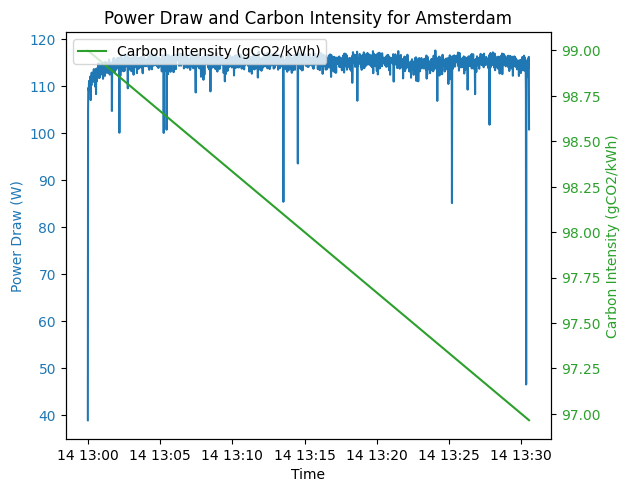

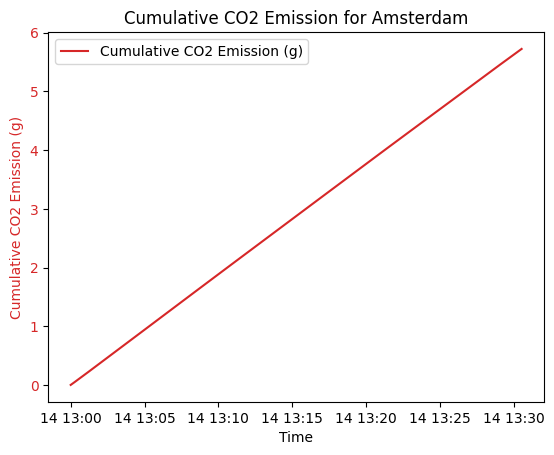

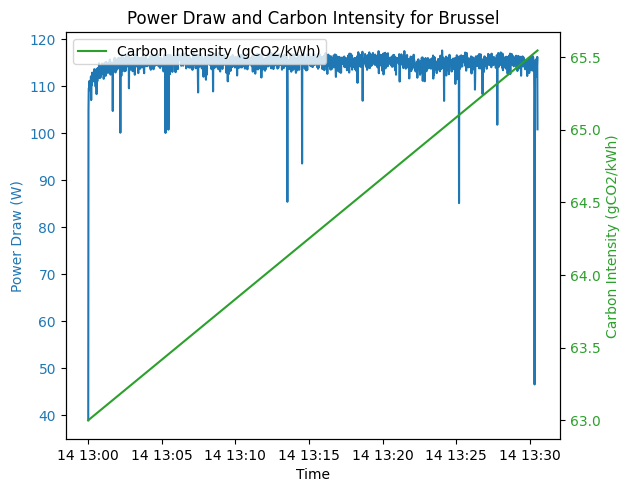

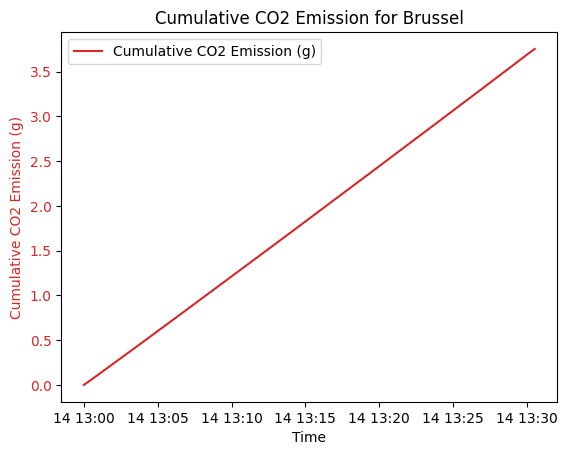

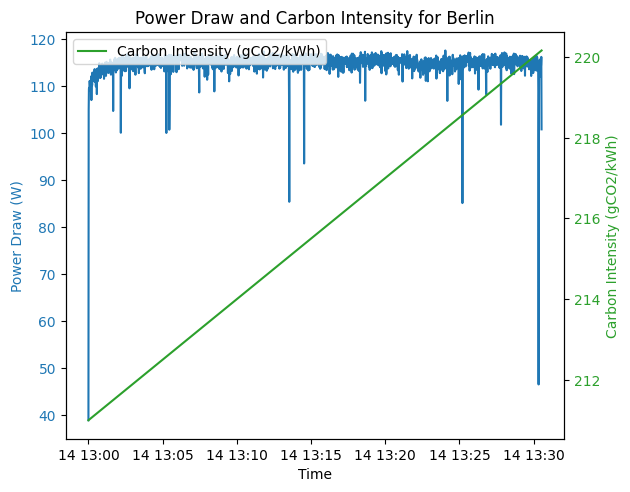

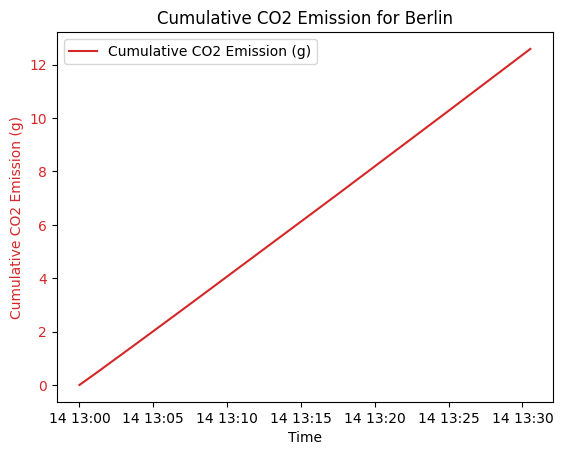

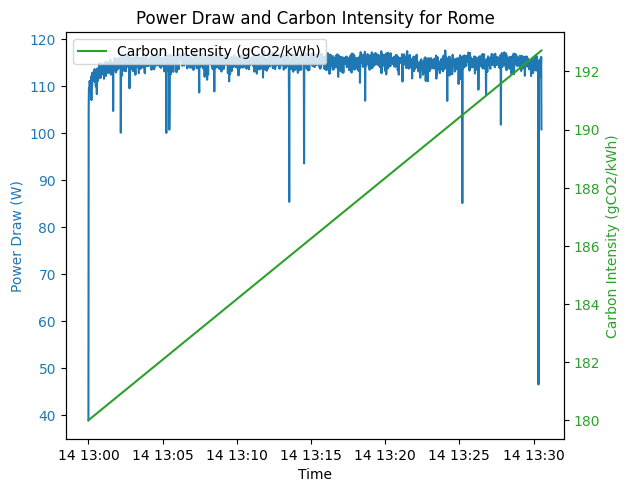

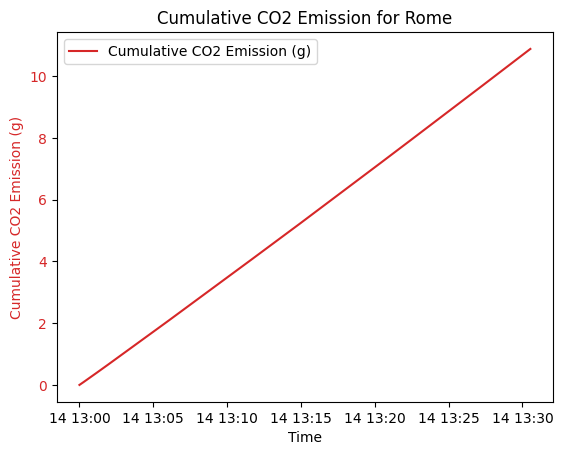

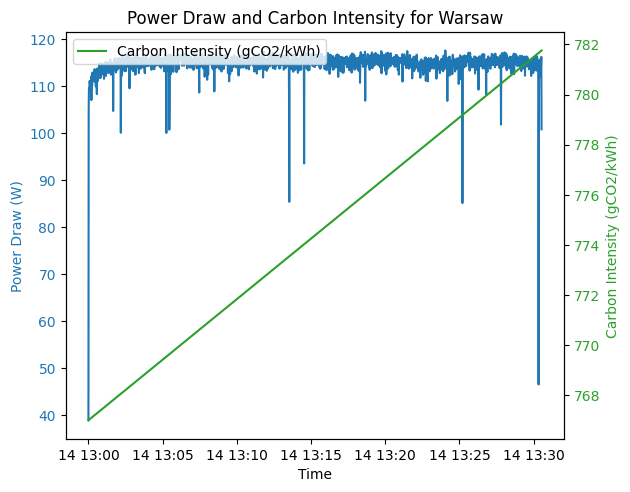

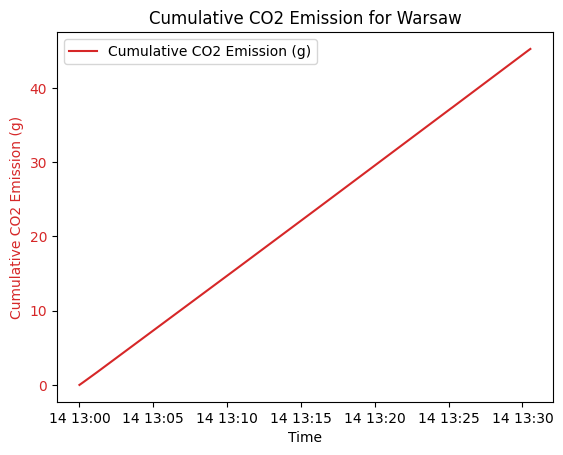

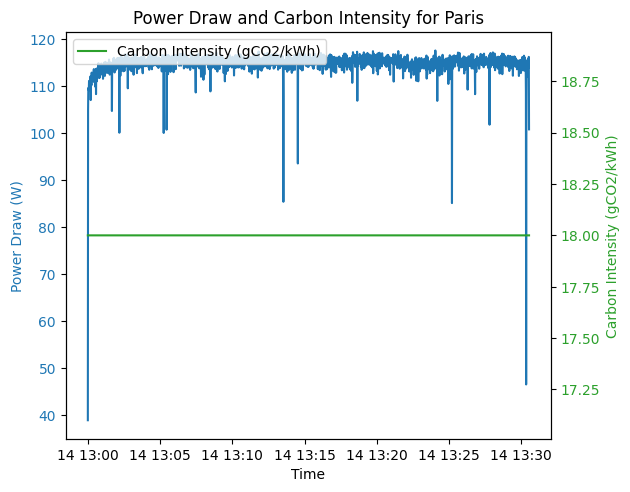

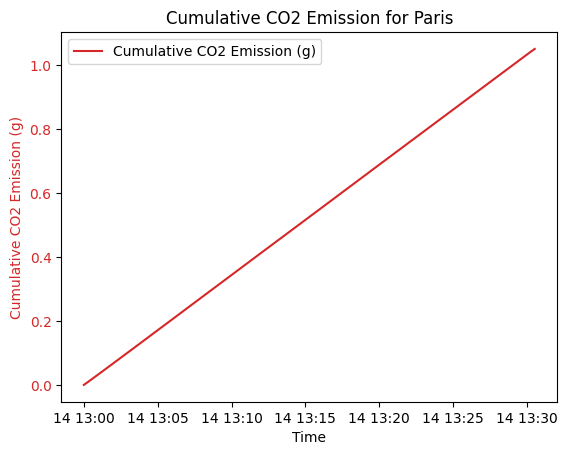

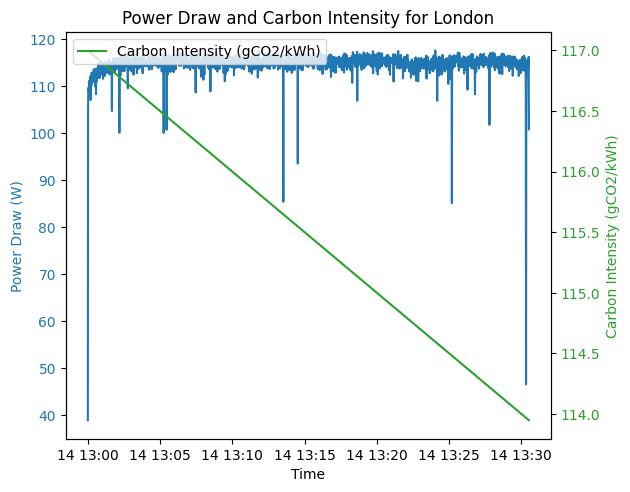

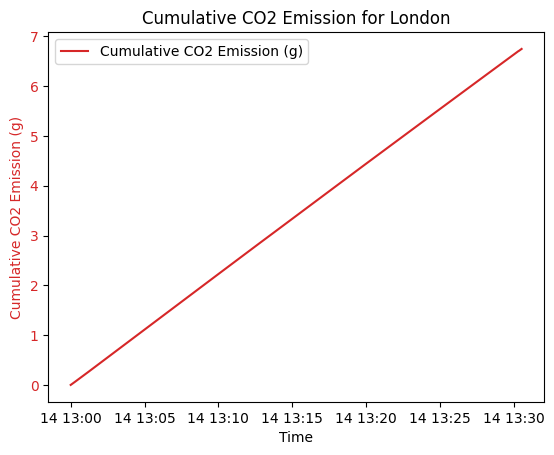

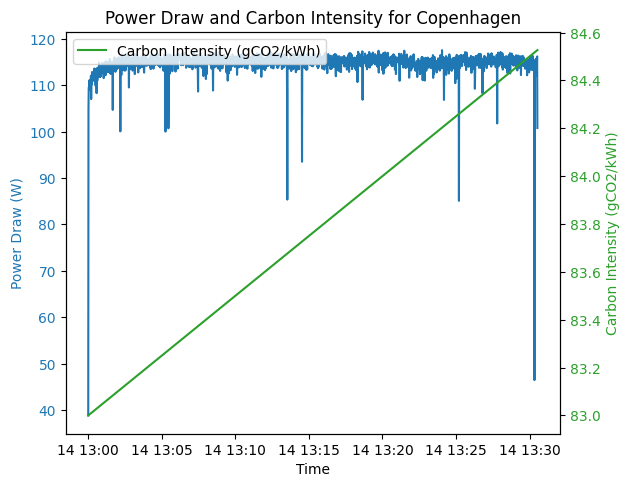

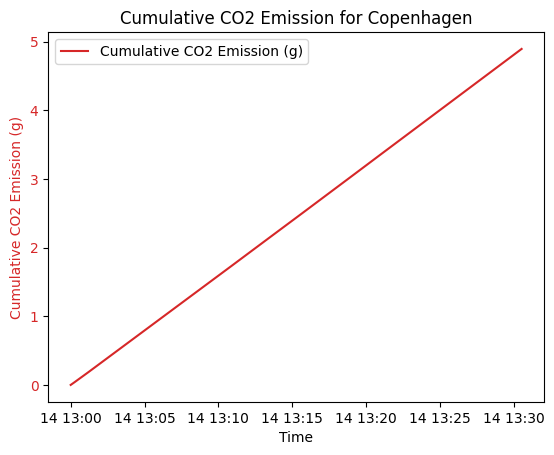

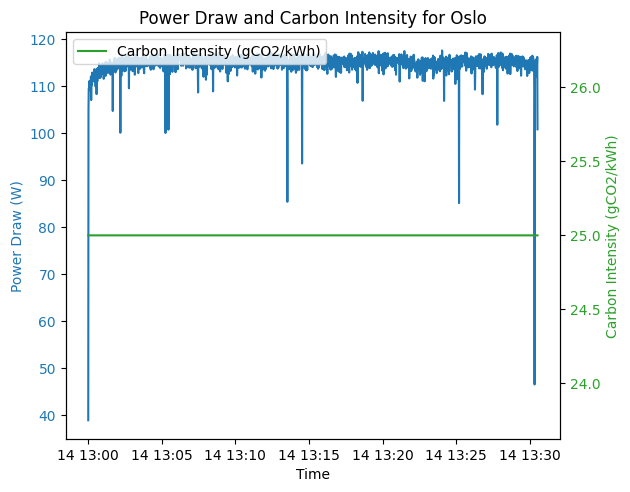

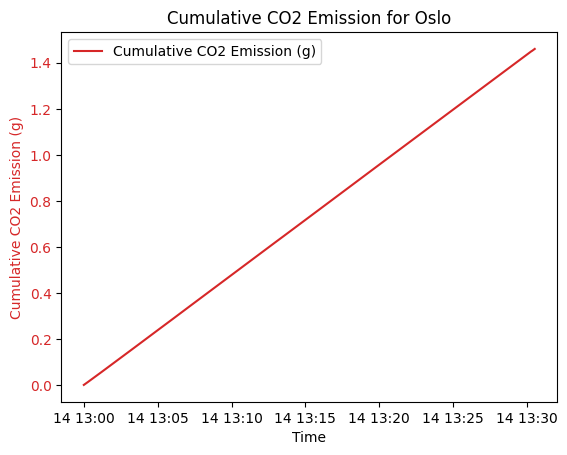

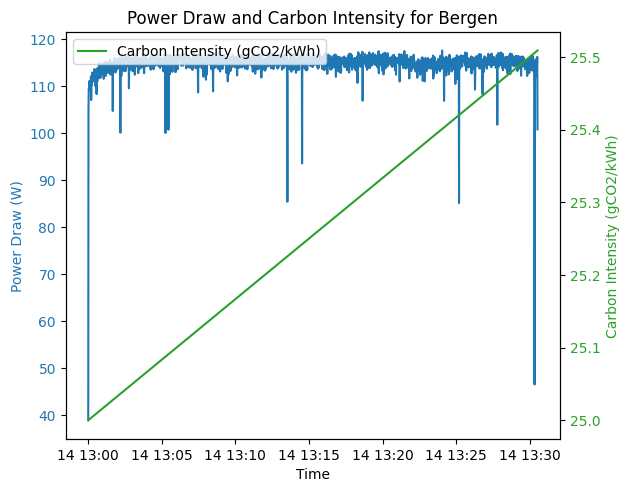

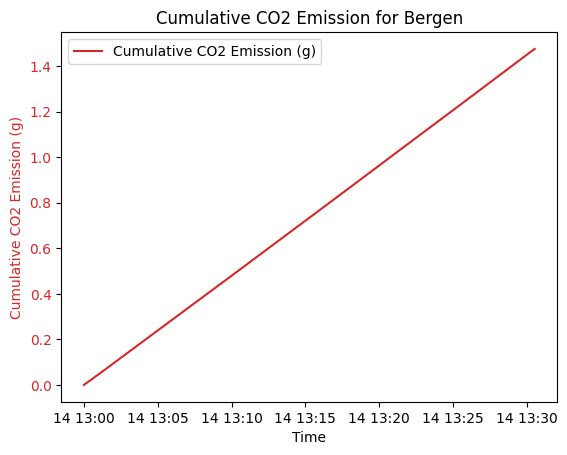

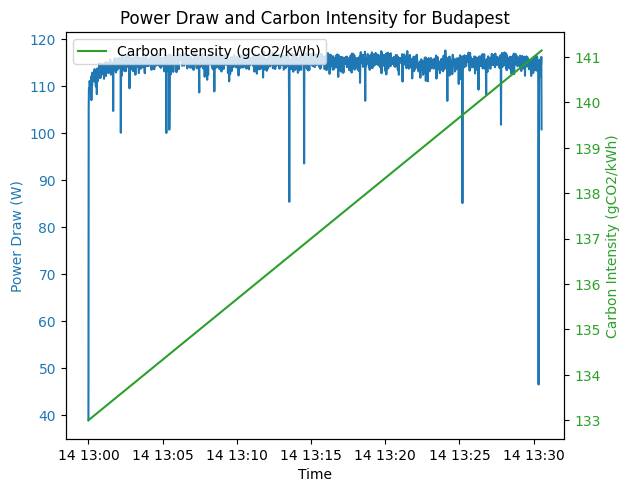

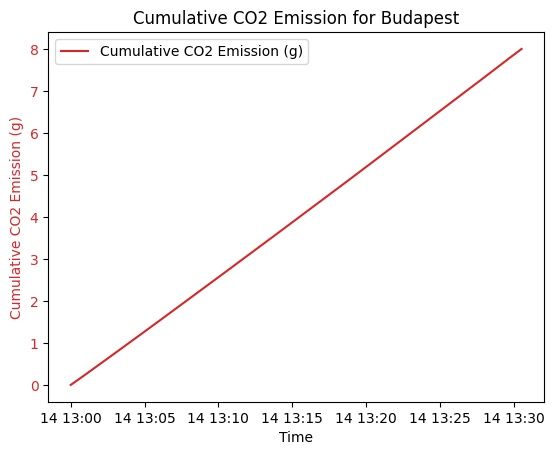

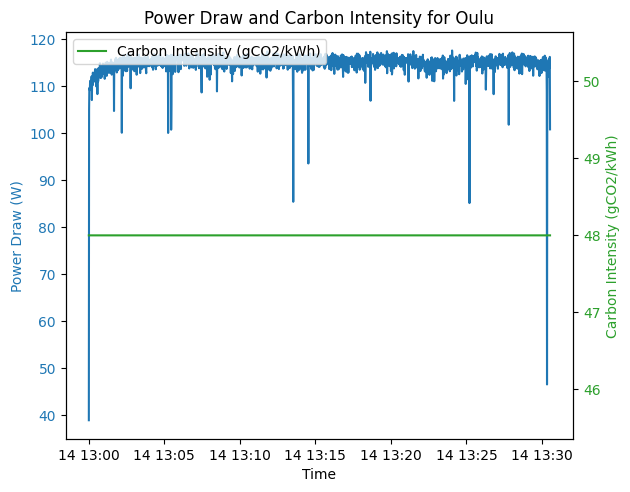

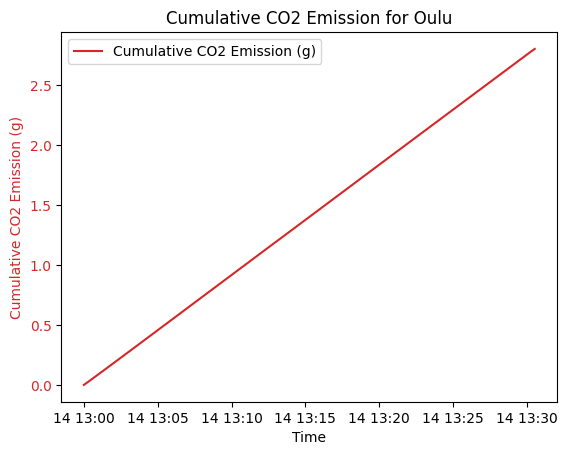

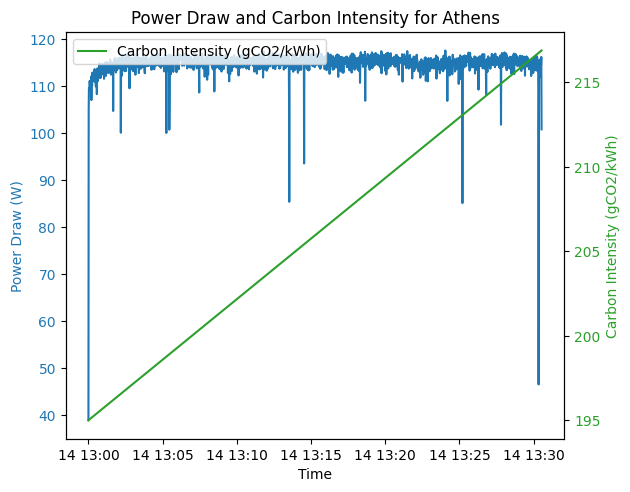

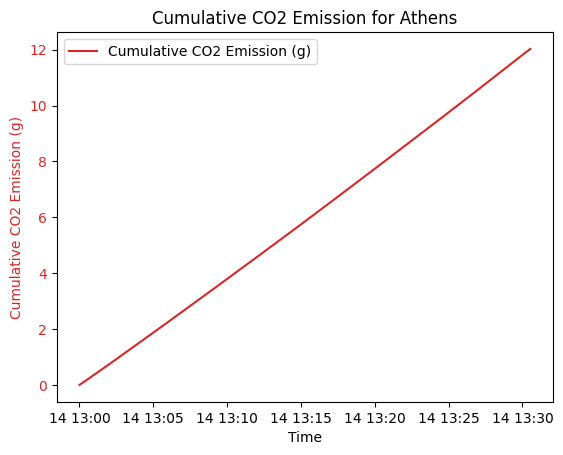

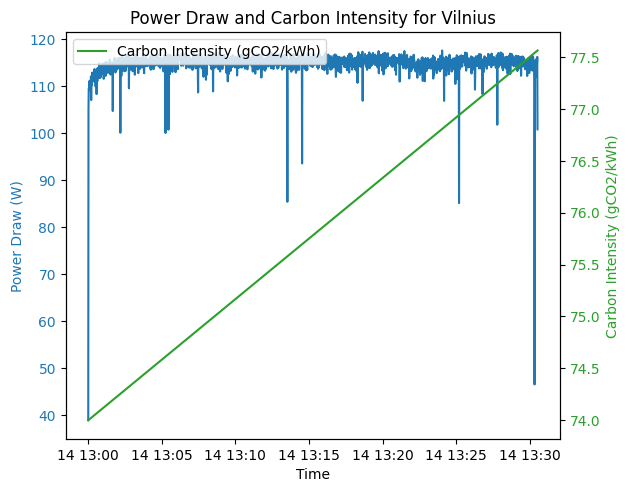

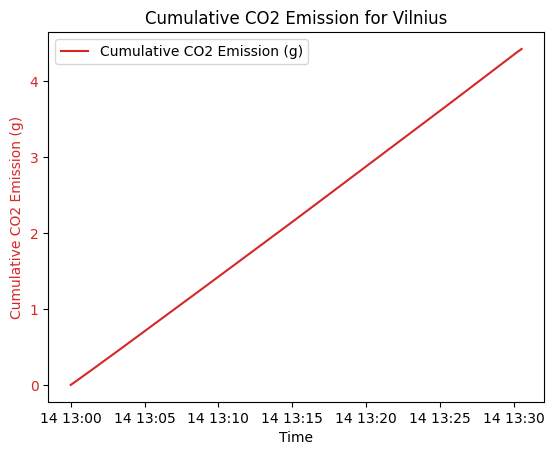

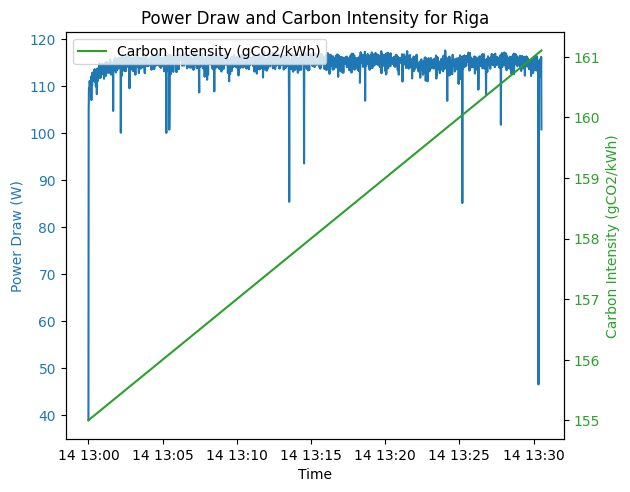

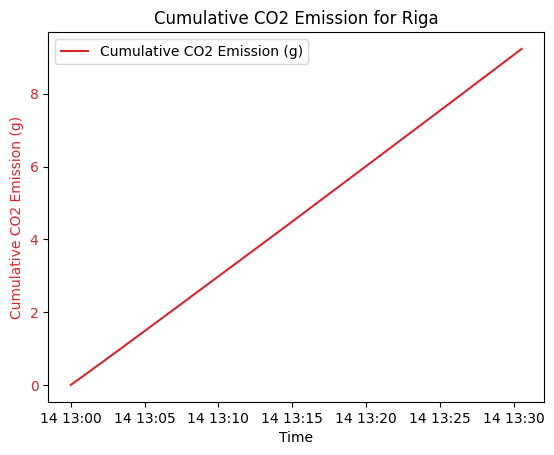

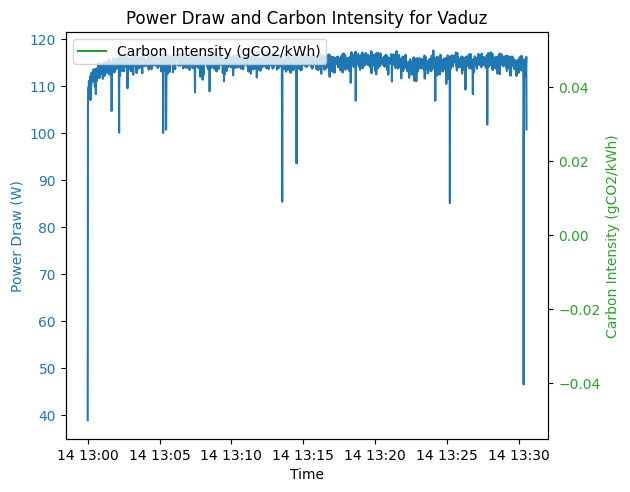

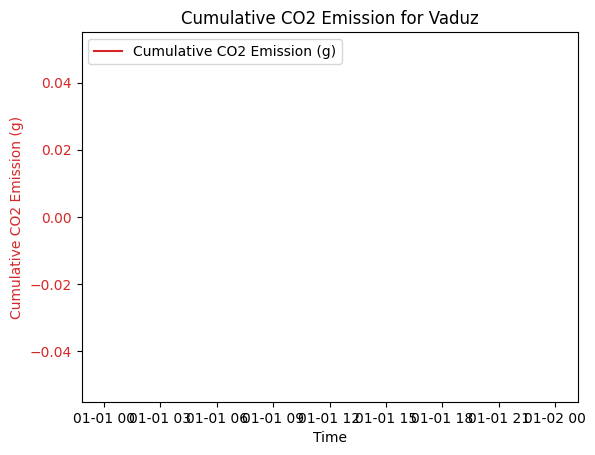

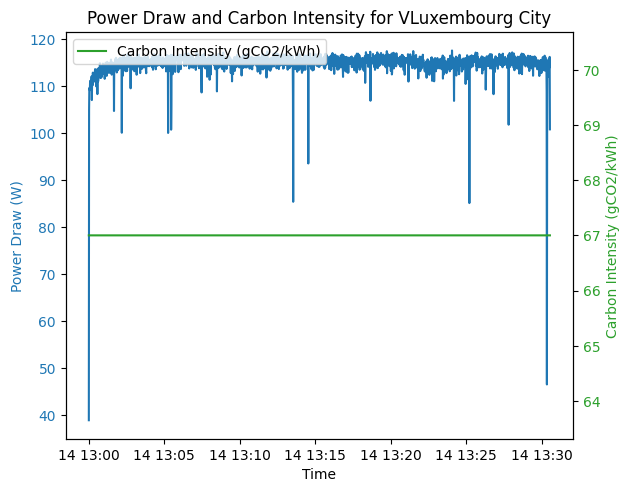

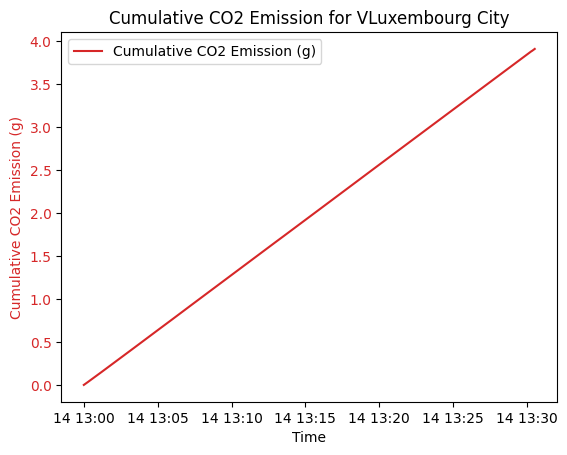

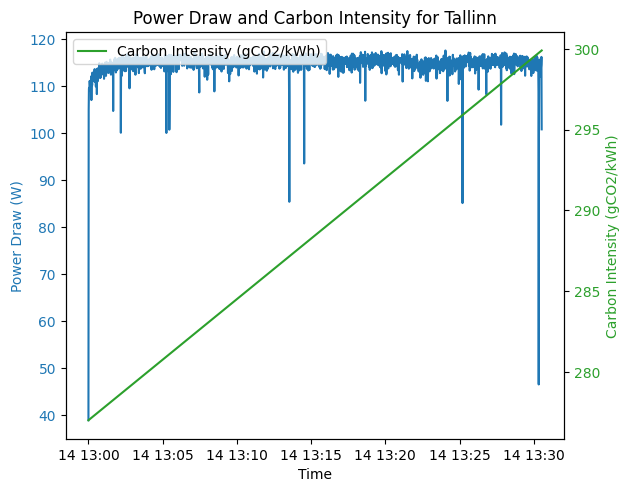

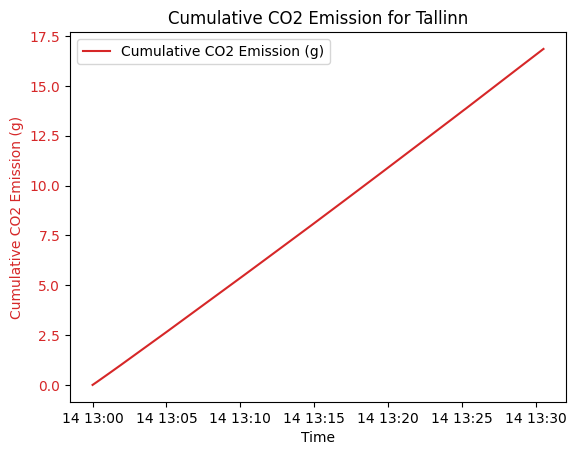

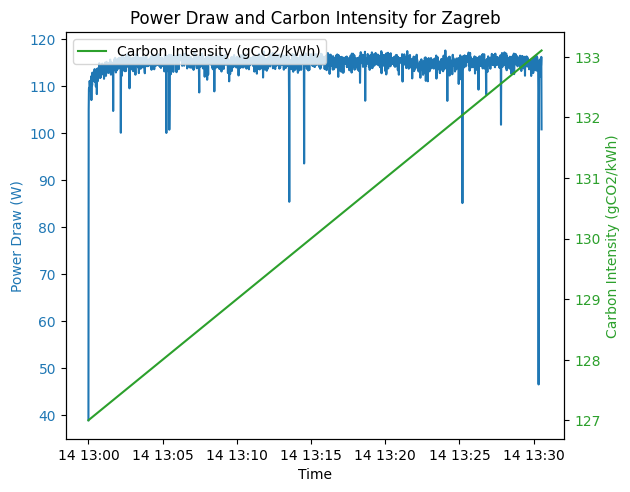

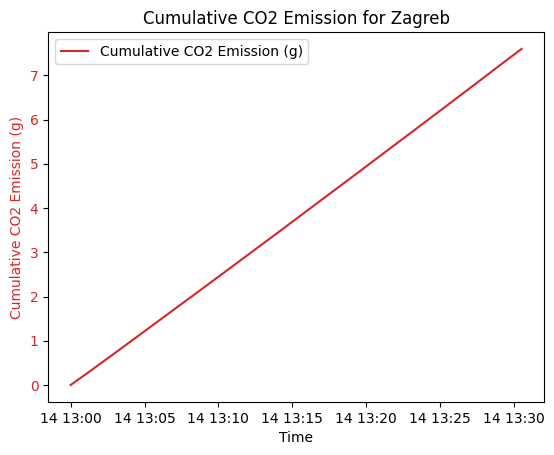

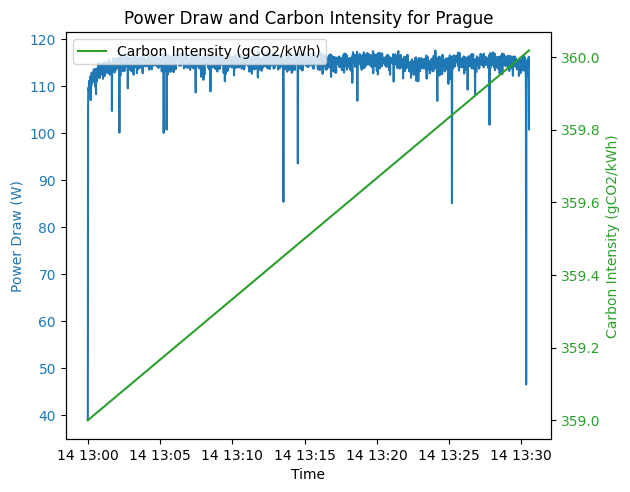

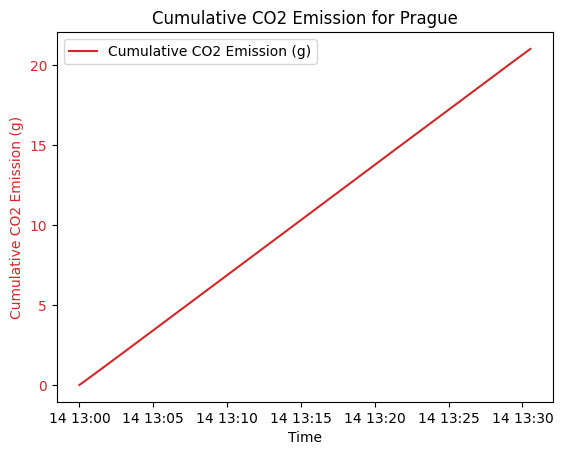

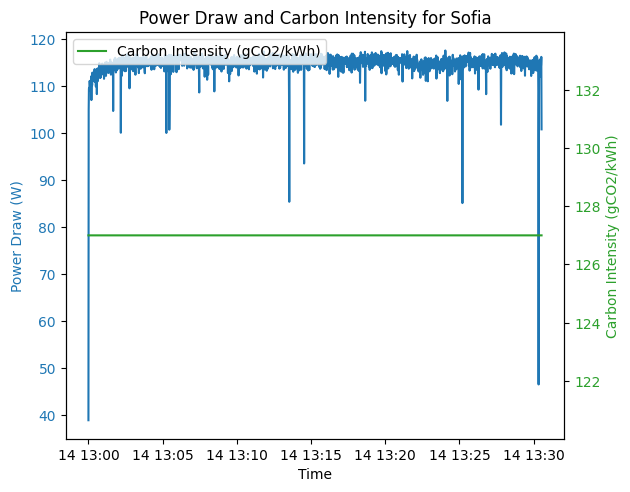

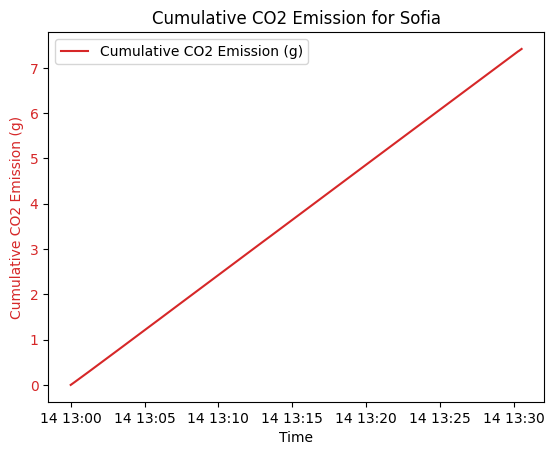

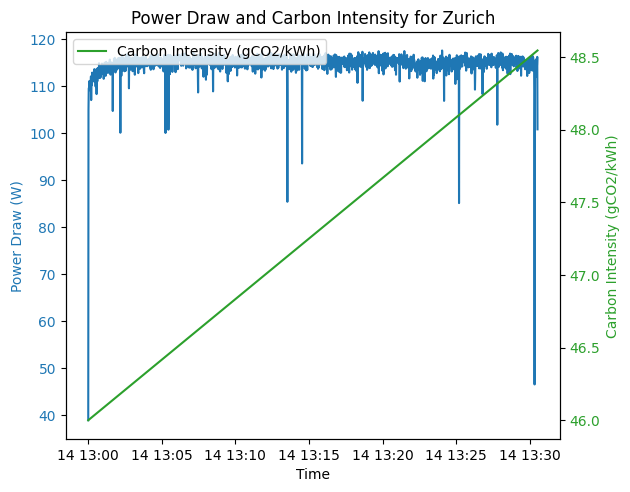

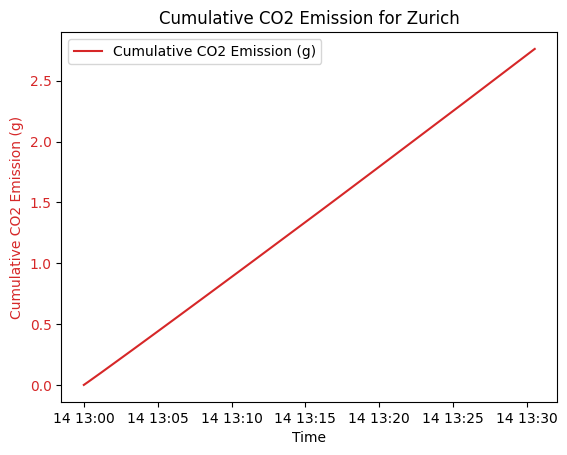

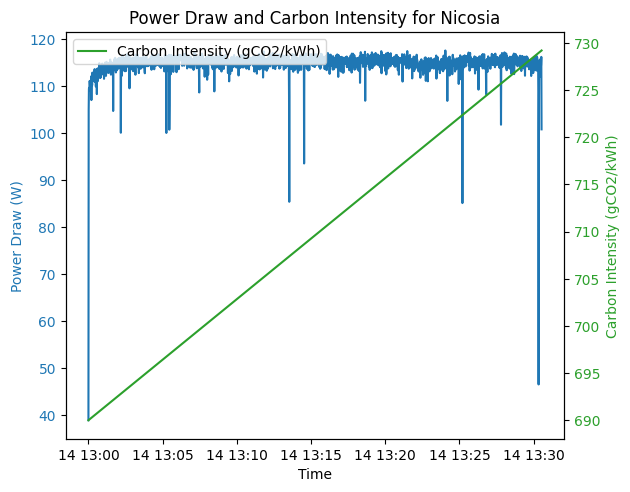

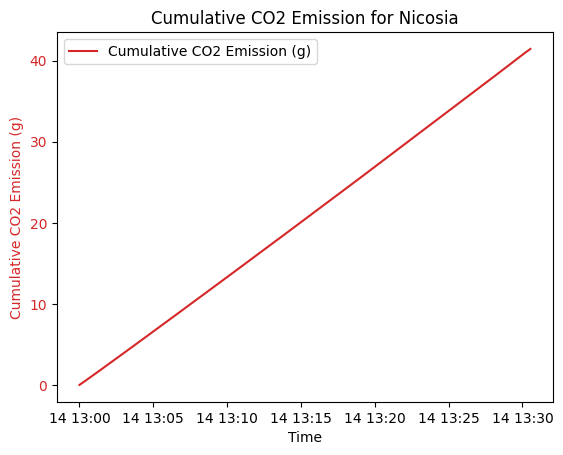

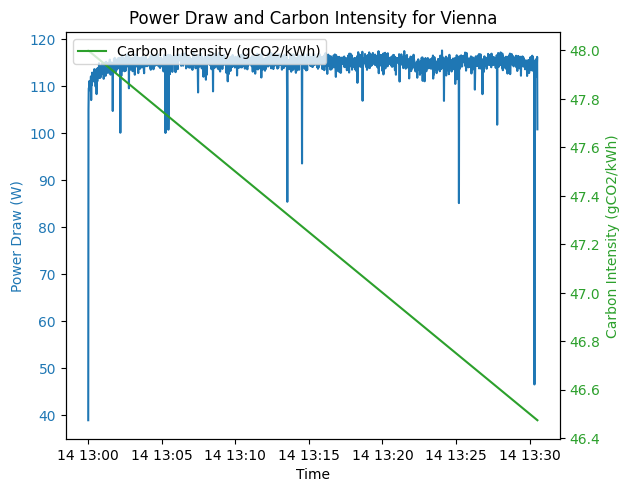

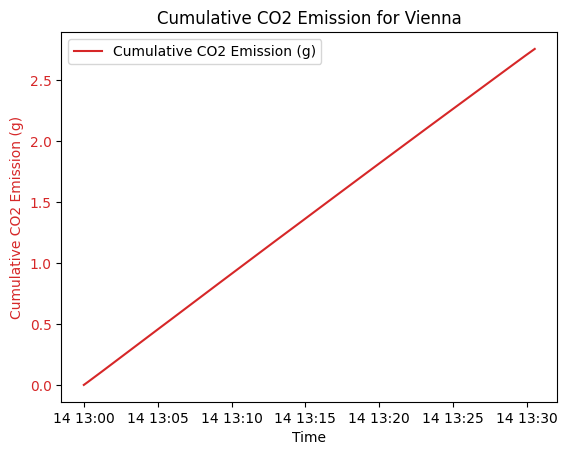

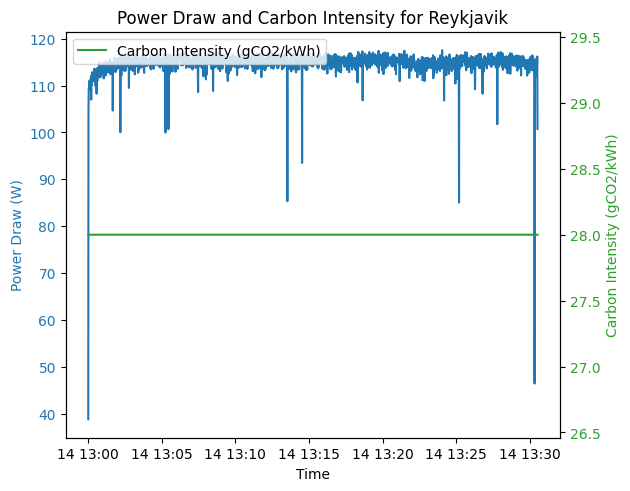

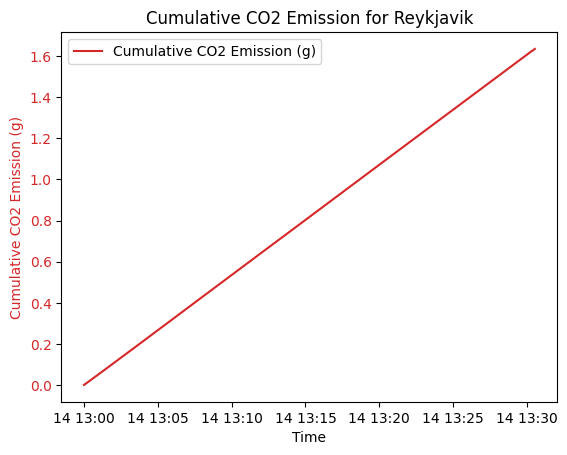

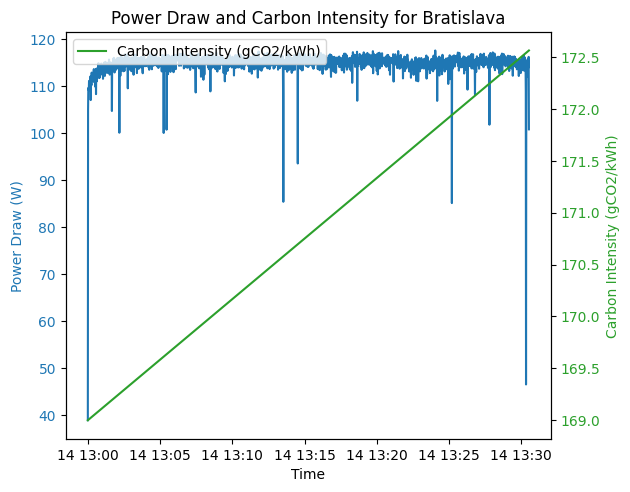

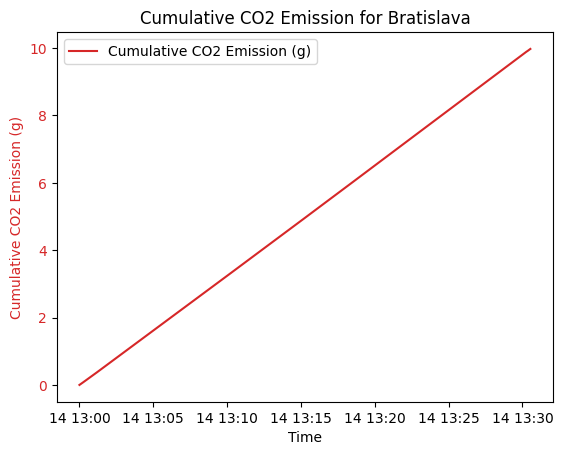

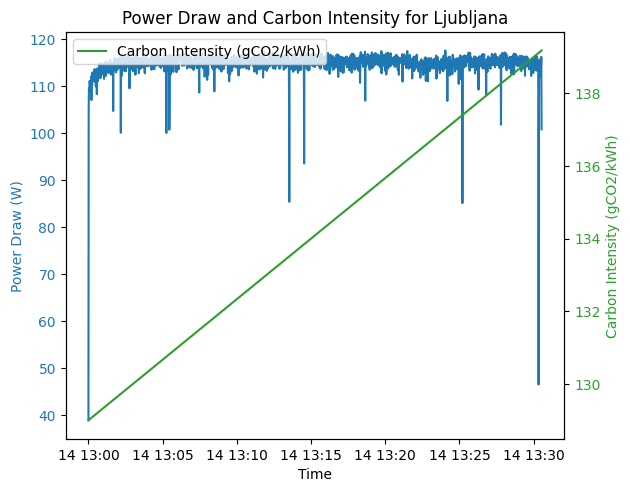

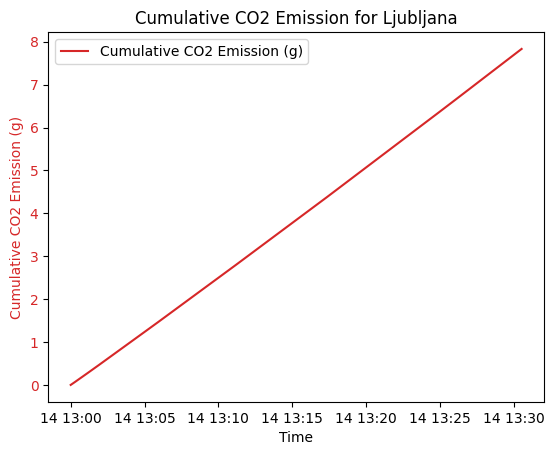

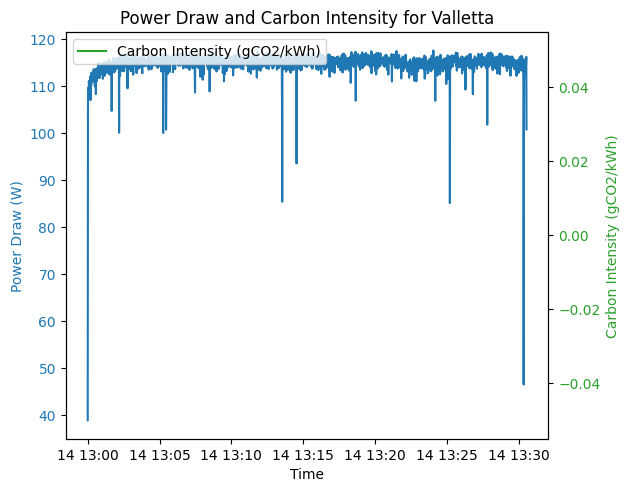

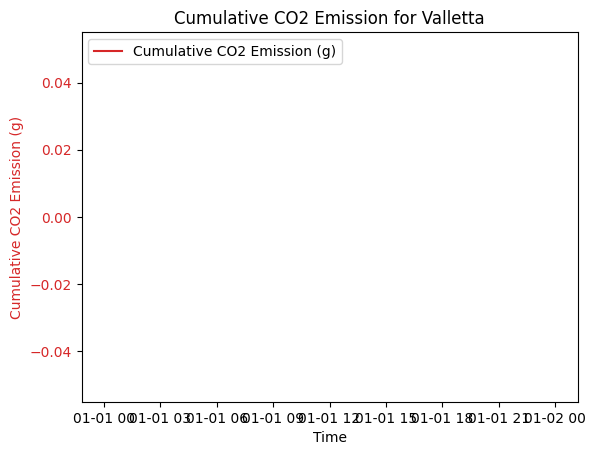

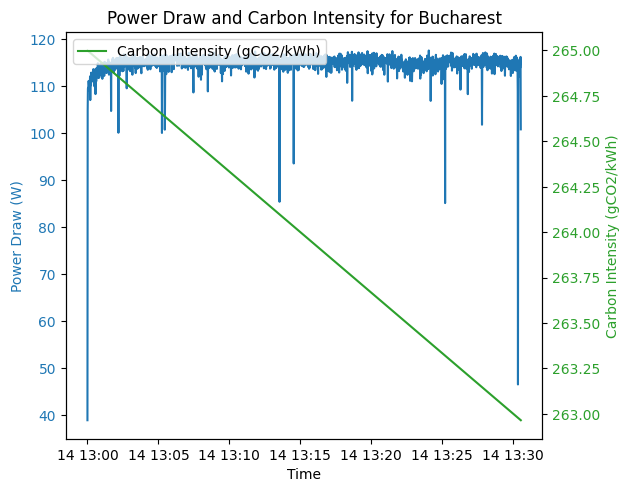

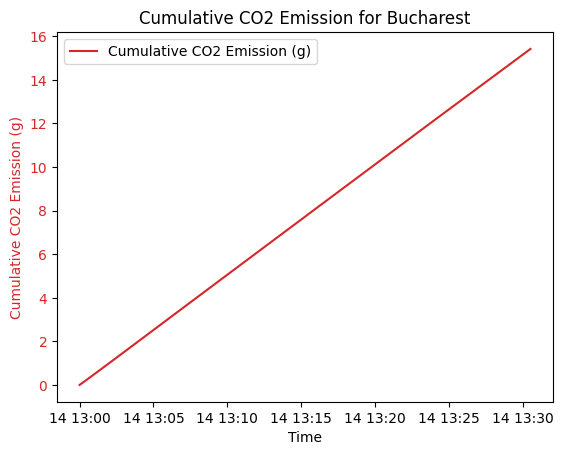

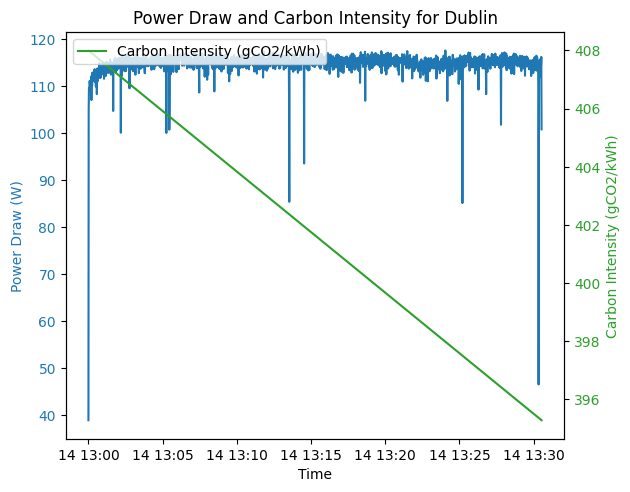

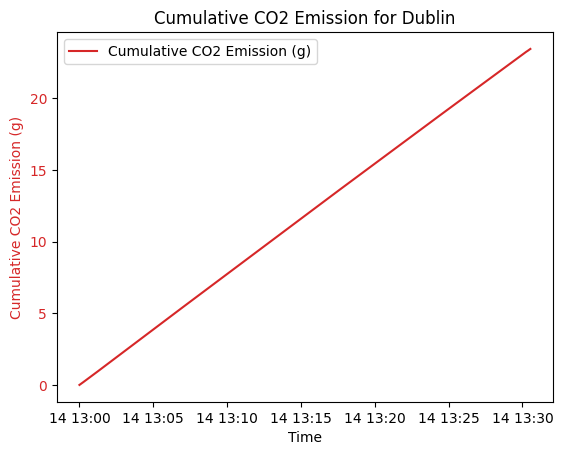

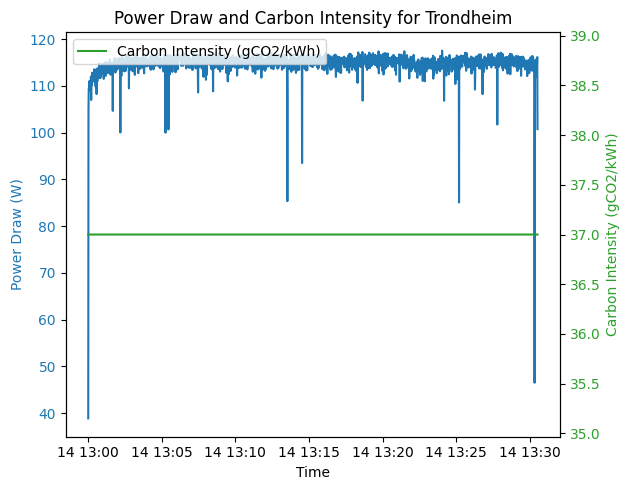

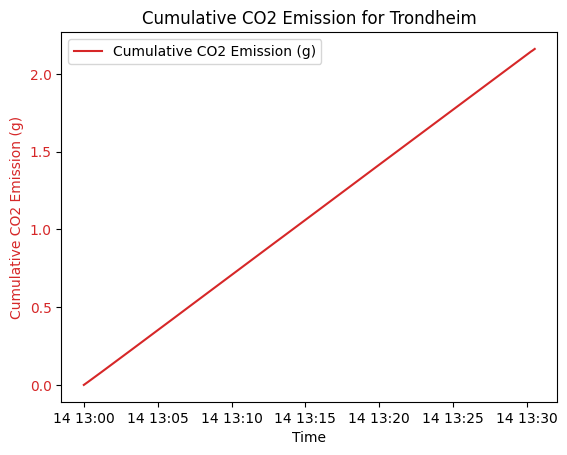

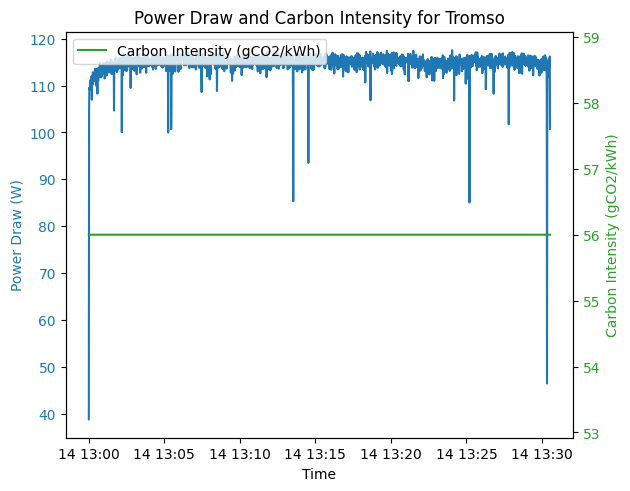

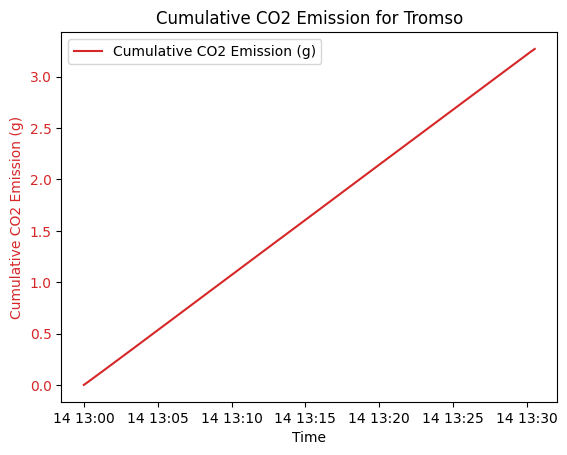

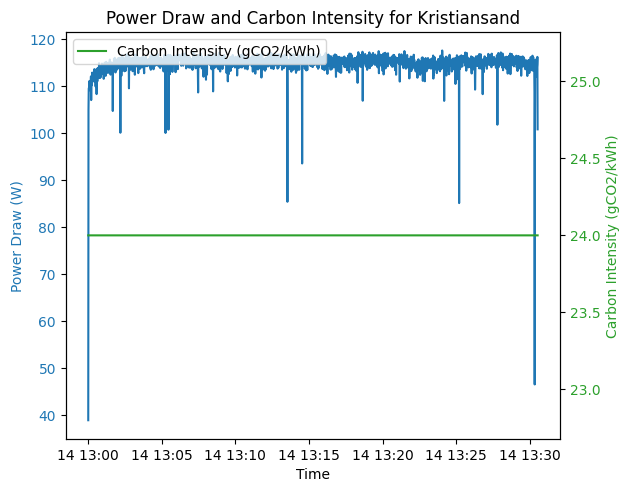

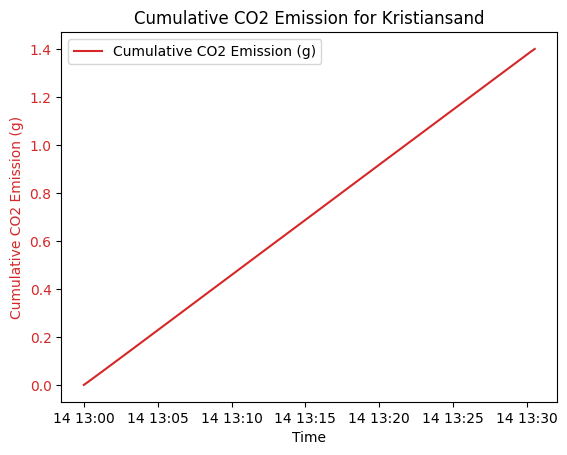

     EdgeCluster  Total CO2 Emission (g)  Total Energy Used (Wh)  Workload Duration (hours)
           Lulea                3.140316               58.409379                   0.508889
       Stockholm                1.153315               58.409379                   0.508889
            Lund                3.140316               58.409379                   0.508889
       Amsterdam                5.723037               58.409379                   0.508889
         Brussel                3.754155               58.409379                   0.508889
          Berlin               12.592090               58.409379                   0.508889
            Rome               10.885509               58.409379                   0.508889
          Warsaw               45.231306               58.409379                   0.508889
           Paris                1.051369               58.409379                   0.508889
          London                6.744660               58.409379                

In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON data
with open('/scratch/cognit/edge-clusters.json', 'r') as file:
    data = json.load(file)

# Function to get the carbon intensity data and interpolate to second-level resolution
def get_carbon_intensity(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)  # Ensure datetime is in UTC
    df = df.set_index('datetime').resample('S').interpolate(method='linear').reset_index()  # Interpolate to second resolution
    return df

# Function to load workload trace data and adjust timestamps
def load_workload_trace(file_path, start_datetime):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_timedelta(df['timestamp'], unit='s') + start_datetime  # Adjust to start from the first date of carbon intensity
    return df

# Function to calculate CO2 emission and energy used
def calculate_emissions_and_energy(power_draw_w, carbon_intensity_gco2_per_kwh):
    # Convert carbon intensity from gCO2/kWh to gCO2/Wh
    carbon_intensity_gco2_per_wh = carbon_intensity_gco2_per_kwh / 1000
    # Calculate energy used in watt-hours (Wh)
    energy_used_wh = power_draw_w / 3600  # since power_draw_w is in watts and we have power draw per second
    # Calculate CO2 emission (gCO2) using the power draw (W) and carbon intensity (gCO2/Wh)
    co2_emission_g = power_draw_w * carbon_intensity_gco2_per_wh / 3600  # in gCO2
    return co2_emission_g, energy_used_wh

# Loop through each entry in the JSON data
results = []
for entry in data:
    name = entry['name']
    carbon_intensity_file = entry['carbon-intensity-trace']
    workload_trace_file = '/scratch/cognit/workloads/0.csv'  # Fixed path to workload trace file

    # Load the carbon intensity data
    carbon_intensity_df = get_carbon_intensity(carbon_intensity_file)
    
    # Get the start date from the carbon intensity data
    start_datetime = carbon_intensity_df['datetime'].min()
    
    # Load the workload trace data and adjust the timestamps
    workload_trace_df = load_workload_trace(workload_trace_file, start_datetime)
    
    # Merge data on the second-level datetime
    merged_df = pd.merge_asof(workload_trace_df.sort_values('timestamp'), 
                              carbon_intensity_df.sort_values('datetime'), 
                              left_on='timestamp', 
                              right_on='datetime',
                              direction='nearest')
    
    # Calculate total CO2 emissions and total energy used
    merged_df[['co2_emission_g', 'energy_used_wh']] = merged_df.apply(
        lambda row: pd.Series(calculate_emissions_and_energy(row['power_draw_W'], row['carbonIntensity'])), axis=1)
    
    total_co2_emission = merged_df['co2_emission_g'].sum()
    total_energy_used_wh = merged_df['energy_used_wh'].sum()
    
    # Calculate workload duration in hours
    workload_duration_hours = (merged_df['timestamp'].max() - merged_df['timestamp'].min()).total_seconds() / 3600
    
    # Store the result
    results.append({
        'EdgeCluster': name, 
        'Total CO2 Emission (g)': total_co2_emission, 
        'Total Energy Used (Wh)': total_energy_used_wh, 
        'Workload Duration (hours)': workload_duration_hours
    })

    # Plotting
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Power Draw (W)', color='tab:blue')
    ax1.plot(merged_df['timestamp'], merged_df['power_draw_W'], color='tab:blue', label='Power Draw (W)')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Carbon Intensity (gCO2/kWh)', color='tab:green')
    ax2.plot(merged_df['timestamp'], merged_df['carbonIntensity'], color='tab:green', label='Carbon Intensity (gCO2/kWh)')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    fig.tight_layout()
    plt.title(f'Power Draw and Carbon Intensity for {name}')
    plt.legend(loc='upper left')
    plt.show()

    fig, ax3 = plt.subplots()
    ax3.plot(merged_df['timestamp'], merged_df['co2_emission_g'].cumsum(), color='tab:red', label='Cumulative CO2 Emission (g)')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Cumulative CO2 Emission (g)', color='tab:red')
    ax3.tick_params(axis='y', labelcolor='tab:red')

    plt.title(f'Cumulative CO2 Emission for {name}')
    plt.legend(loc='upper left')
    plt.show()

# Convert results to a DataFrame and display without index
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
